In [1]:
import pandas as pd
import numpy as np
import sqlite3
import pathlib

# Configura o caminho para o banco de dados
# (Assumindo que o notebook está na pasta raiz 'ML Avancado')
project_root = pathlib.Path("..") # Sobe um nível (para a raiz 'ML Avancado')
db_path = project_root / "banco de dados" / "crash_bot_historico.db"

print(f"Carregando dados de: {db_path}")

try:
    with sqlite3.connect(db_path) as conn:
        query = "SELECT timestamp, multiplicador FROM multiplicadores_historico ORDER BY timestamp ASC"
        df = pd.read_sql_query(query, conn, parse_dates=["timestamp"])
    
    df = df.set_index("timestamp").sort_index()
    print(f"Sucesso: {len(df)} rodadas carregadas do banco de dados.")
    
    # Exibe as últimas 5 rodadas para confirmar
    print("\nÚltimas 5 rodadas carregadas:")
    display(df.tail())

except Exception as e:
    print(f"Erro ao carregar dados: {e}")

Carregando dados de: ..\banco de dados\crash_bot_historico.db
Sucesso: 23448 rodadas carregadas do banco de dados.

Últimas 5 rodadas carregadas:


,multiplicador
timestamp,
2025-11-17 13:28:00.154474,1.14
2025-11-17 13:28:24.751285,2.62
2025-11-17 13:28:56.894346,6.19
2025-11-17 13:29:18.592977,1.58
2025-11-17 13:29:47.034418,4.65


In [2]:
# --- CÉLULA 2 (MODIFICADA COM A MÉTRICA DO TCS) ---

TARGET_MULTIPLIER = 2.0
TRAGEDY_STREAK_LENGTH = 12 # Definimos a "Tragédia" como 12 baixos

# 'df' é a variável carregada da Célula 1
df_featured = df.copy()

# 1. Criar 'low_streak' (Seu código original)
print("Calculando 'low_streak'...")
is_low = df_featured["multiplicador"] < TARGET_MULTIPLIER
cumulative_lows = is_low.astype(int).cumsum()
streak_breaks = cumulative_lows.where(~is_low)
filled_breaks = streak_breaks.ffill().fillna(0)
df_featured["low_streak"] = (cumulative_lows - filled_breaks).astype(int)

# 2. Criar o ALVO (TARGET): "A Tragédia" (Seu código original)
print(f"Identificando 'target_tragedy' (streaks >= {TRAGEDY_STREAK_LENGTH})...")
df_featured['target_tragedy'] = (df_featured['low_streak'] >= TRAGEDY_STREAK_LENGTH).astype(int)

# 3. Criar os "SINAIS" (Volatilidade Bruta - Seu código original)
print("Calculando features de janela longa (Volatilidade Bruta)...")
window_sizes = [20, 30, 50, 100, 250] 

for window in window_sizes:
    # Usamos shift(1) para que os cálculos se refiram ao *passado*
    rolling_series = df_featured["multiplicador"].shift(1).rolling(window=window)
    
    df_featured[f'rolling_mean_{window}'] = rolling_series.mean()
    df_featured[f'rolling_std_{window}'] = rolling_series.std()

# --- 4. INJEÇÃO DA MÉTRICA DO TCS (O PASSO NOVO) ---
print("\n--- INJETANDO CÁLCULO DO TCS (LOG-RETURNS) ---")
print("Calculando 'log_return'...")
# Esta é a métrica exata do strategy_engine.py
df_featured['log_return'] = np.log(df_featured['multiplicador'].replace(0, 1e-9) / df_featured['multiplicador'].shift(1).replace(0, 1e-9))

print("Calculando 'volatilidade_tcs_250'...")
# Esta é a coluna do nosso "VETO DE SEGURANÇA"
df_featured['volatilidade_tcs_250'] = df_featured['log_return'].rolling(window=250, min_periods=50).std()
print("--- CÁLCULO DO TCS CONCLUÍDO ---\n")
# --- FIM DA INJEÇÃO ---

# 5. Limpar dados (Seu código original)
# O .dropna() agora também limpará os NaNs da 'volatilidade_tcs_250'
df_final = df_featured.dropna().copy()

print(f"\nEngenharia de features concluída. {len(df_final)} amostras prontas para análise.")
print("VERIFICAÇÃO: Novas colunas 'log_return' e 'volatilidade_tcs_250' foram adicionadas.")
display(df_final.tail())

Calculando 'low_streak'...
Identificando 'target_tragedy' (streaks >= 12)...
Calculando features de janela longa (Volatilidade Bruta)...

--- INJETANDO CÁLCULO DO TCS (LOG-RETURNS) ---
Calculando 'log_return'...
Calculando 'volatilidade_tcs_250'...
--- CÁLCULO DO TCS CONCLUÍDO ---


Engenharia de features concluída. 23198 amostras prontas para análise.
VERIFICAÇÃO: Novas colunas 'log_return' e 'volatilidade_tcs_250' foram adicionadas.


,multiplicador,low_streak,target_tragedy,rolling_mean_20,rolling_std_20,rolling_mean_30,rolling_std_30,rolling_mean_50,rolling_std_50,rolling_mean_100,rolling_std_100,rolling_mean_250,rolling_std_250,log_return,volatilidade_tcs_250
timestamp,,,,,,,,,,,,,,,
2025-11-17 13:28:00.154474,1.14,4,0,3.6730,5.277629,4.739667,10.492732,4.9608,10.148974,5.2998,10.652949,6.62752,17.992948,0.017700,1.311402
2025-11-17 13:28:24.751285,2.62,0,0,3.4665,5.292631,4.712333,10.501287,4.9318,10.157955,5.2907,10.656141,6.59200,17.994989,0.832146,1.305523
2025-11-17 13:28:56.894346,6.19,0,0,3.5345,5.271484,2.960000,4.403356,4.8422,10.158198,5.2750,10.658936,6.59772,17.993492,0.859761,1.299667
2025-11-17 13:29:18.592977,1.58,1,0,3.7385,5.292360,3.112333,4.434341,4.9460,10.144643,5.2896,10.659181,6.58240,17.992197,-1.365510,1.302488
2025-11-17 13:29:47.034418,4.65,0,0,3.7380,5.292574,3.092333,4.440040,4.9544,10.141618,5.2909,10.658716,6.55460,17.994545,1.079442,1.297636


In [3]:
# --- CÉLULA 3: Mapeamento do Clima Preditivo ---
# (Usa a variável 'df_final' da Célula 2)

# O período que queremos analisar ANTES da tragédia
LOOKAHEAD_WINDOW = 250

def map_clima_preditivo(row):
    # Se esta linha é o *início* de uma tragédia (streak >= 12)
    if row['target_tragedy'] == 1:
        return 'In_Tragedy'
    else:
        return 'Normal'

print("Mapeando 'clima_preditivo' (Normal e In_Tragedy)...")
# Primeiro, rotulamos tudo como Normal ou In_Tragedy
df_final['clima_preditivo'] = df_final.apply(map_clima_preditivo, axis=1)

# Agora, o passo mais importante: rotular o "Pré-Tragédia"
# Encontramos os índices onde a tragédia começa
tragedy_indices = df_final[df_final['clima_preditivo'] == 'In_Tragedy'].index

print(f"Encontradas {len(tragedy_indices)} 'Tragédias' (pontos de início).")
print(f"Mapeando os {LOOKAHEAD_WINDOW} períodos 'Pré-Tragédia' para cada...")

for idx in tragedy_indices:
    # Encontra o índice numérico da linha da tragédia
    loc = df_final.index.get_loc(idx)
    
    # Define o "período de risco" (as 250 rodadas ANTES)
    start_loc = max(0, loc - LOOKAHEAD_WINDOW)
    end_loc = loc
    
    # Rotula todas as linhas 'Normais' nesse período como 'Pre_Tragedy'
    df_final.iloc[start_loc:end_loc] = df_final.iloc[start_loc:end_loc].replace(
        {'clima_preditivo': 'Normal'}, 'Pre_Tragedy'
    )

print("\n--- Mapeamento Concluído! ---")
print("Contagem final dos tipos de clima:")
print(df_final['clima_preditivo'].value_counts())

Mapeando 'clima_preditivo' (Normal e In_Tragedy)...
Encontradas 7 'Tragédias' (pontos de início).
Mapeando os 250 períodos 'Pré-Tragédia' para cada...

--- Mapeamento Concluído! ---
Contagem final dos tipos de clima:
clima_preditivo
Normal         22191
Pre_Tragedy     1000
In_Tragedy         7
Name: count, dtype: int64


In [4]:
# --- CÉLULA 4: A ANÁLISE FOCADA (A "Biópsia") ---
# (Usa a variável 'df_final' da Célula 3)

# 1. Separar os grupos (Normal vs. Pré-Risco)
clima_normal = df_final[df_final['clima_preditivo'] == 'Normal']
clima_pre_tragedia = df_final[df_final['clima_preditivo'] == 'Pre_Tragedy']

# 2. Definir a coluna correta (a do TCS que criamos)
coluna_de_analise = 'volatilidade_tcs_250'

print(f"--- 🩺 DIAGNÓSTICO (Baseado em {len(df_final)} amostras) ---")
print(f"Analisando {len(clima_normal)} amostras 'Normais' vs. {len(clima_pre_tragedia)} 'Pré-Tragédia'.")

# 3. Gerar as estatísticas (A "Biópsia")
print("\n--- Estatísticas do Clima 'NORMAL' (Métrica TCS) ---")
stats_normal = clima_normal[coluna_de_analise].describe(percentiles=[.5, .75, .90, .95, .99])
print(stats_normal)

print("\n--- Estatísticas do Clima 'PRÉ-TRAGÉDIA' (Métrica TCS) ---")
stats_pre_tragedia = clima_pre_tragedia[coluna_de_analise].describe(percentiles=[.5, .75, .90, .95, .99])
print(stats_pre_tragedia)

# 4. A Conclusão (Validando nosso Limite de 2.5)
print("\n--- 🔬 CONCLUSÃO: CALIBRAÇÃO DO TCS (Limite de 2.5) ---")

limite_tcs_atual = 2.5

falsos_positivos_pct = (clima_normal[coluna_de_analise] > limite_tcs_atual).mean() * 100
captura_real_pct = (clima_pre_tragedia[coluna_de_analise] > limite_tcs_atual).mean() * 100

print(f"Nosso limite de {limite_tcs_atual:.1f} está vetando {falsos_positivos_pct:.2f}% do tempo 'Normal' (Falsos Positivos).")
print(f"Nosso limite de {limite_tcs_atual:.1f} está capturando {captura_real_pct:.2f}% do tempo de 'Pré-Tragédia' (Captura Correta).")

--- 🩺 DIAGNÓSTICO (Baseado em 23198 amostras) ---
Analisando 22191 amostras 'Normais' vs. 1000 'Pré-Tragédia'.

--- Estatísticas do Clima 'NORMAL' (Métrica TCS) ---
count    22191.000000
mean         1.304223
std          0.105147
min          0.972275
50%          1.302815
75%          1.372335
90%          1.439086
95%          1.486698
99%          1.559074
max          1.627784
Name: volatilidade_tcs_250, dtype: float64

--- Estatísticas do Clima 'PRÉ-TRAGÉDIA' (Métrica TCS) ---
count    1000.000000
mean        1.320898
std         0.069976
min         1.107529
50%         1.338121
75%         1.373449
90%         1.397047
95%         1.421123
99%         1.434915
max         1.441249
Name: volatilidade_tcs_250, dtype: float64

--- 🔬 CONCLUSÃO: CALIBRAÇÃO DO TCS (Limite de 2.5) ---
Nosso limite de 2.5 está vetando 0.00% do tempo 'Normal' (Falsos Positivos).
Nosso limite de 2.5 está capturando 0.00% do tempo de 'Pré-Tragédia' (Captura Correta).


In [5]:
# --- CÉLULA 5: BIÓPSIA 2.0 (Foco no Veto Interno do Bot) ---

# 1. Separar os grupos (Normal vs. Pré-Risco)
clima_normal = df_final[df_final['clima_preditivo'] == 'Normal']
clima_pre_tragedia = df_final[df_final['clima_preditivo'] == 'Pre_Tragedy']

# 2. Definir a coluna correta (a do Veto Interno do bot)
coluna_de_analise = 'rolling_std_20' # <--- A MUDANÇA ESTÁ AQUI

print(f"--- 🩺 DIAGNÓSTICO DO VETO INTERNO (rolling_std_20) ---")
print(f"Analisando {len(clima_normal)} amostras 'Normais' vs. {len(clima_pre_tragedia)} 'Pré-Tragédia'.")

# 3. Gerar as estatísticas (A "Biópsia")
print(f"\n--- Estatísticas 'NORMAL' ({coluna_de_analise}) ---")
stats_normal = clima_normal[coluna_de_analise].describe(percentiles=[.10, .25, .5, .75, .90])
print(stats_normal)

print(f"\n--- Estatísticas 'PRÉ-TRAGÉDIA' ({coluna_de_analise}) ---")
stats_pre_tragedia = clima_pre_tragedia[coluna_de_analise].describe(percentiles=[.10, .25, .5, .75, .90])
print(stats_pre_tragedia)

# 4. A Conclusão (Validando o Veto Interno do Bot)
print("\n--- 🔬 CONCLUSÃO: CALIBRAÇÃO DO VETO INTERNO (Limite < 2.0) ---")

limite_de_calma_do_bot = 2.0 # O limite do seu _check_safety_conditions

# Calculamos o oposto:
# Quantas rodadas 'Normais' são "calmas" (abaixo do limite)?
normais_calmas_pct = (clima_normal[coluna_de_analise] < limite_de_calma_do_bot).mean() * 100

# Quantas 'Pré-Tragédias' são "calmas" (abaixo do limite)?
tragedias_calmas_pct = (clima_pre_tragedia[coluna_de_analise] < limite_de_calma_do_bot).mean() * 100

print(f"O seu Veto (< {limite_de_calma_do_bot}) está vetando {normais_calmas_pct:.2f}% do tempo 'Normal'.")
print(f"O seu Veto (< {limite_de_calma_do_bot}) está (corretamente) vetando {tragedias_calmas_pct:.2f}% do tempo de 'Pré-Tragédia'.")

if tragedias_calmas_pct > normais_calmas_pct:
    print("\n[DIAGNÓSTICO PRELIMINAR] ✅ POSITIVO. O 'clima Pré-Tragédia' parece ser, de fato, mais 'calmo' que o 'Normal'.")
else:
    print("\n[DIAGNÓSTICO PRELIMINAR] ❌ NEGATIVO. O 'clima Pré-Tragédia' NÃO é mais 'calmo' que o 'Normal'.")

--- 🩺 DIAGNÓSTICO DO VETO INTERNO (rolling_std_20) ---
Analisando 22191 amostras 'Normais' vs. 1000 'Pré-Tragédia'.

--- Estatísticas 'NORMAL' (rolling_std_20) ---
count    22191.000000
mean        11.597211
std         13.106045
min          0.524534
10%          1.951251
25%          2.424024
50%          5.050945
75%         14.574439
90%         34.348791
max         62.328396
Name: rolling_std_20, dtype: float64

--- Estatísticas 'PRÉ-TRAGÉDIA' (rolling_std_20) ---
count    1000.000000
mean       10.388136
std        13.494444
min         0.921109
10%         1.850139
25%         2.276177
50%         2.927388
75%        12.513807
90%        33.762639
max        59.866607
Name: rolling_std_20, dtype: float64

--- 🔬 CONCLUSÃO: CALIBRAÇÃO DO VETO INTERNO (Limite < 2.0) ---
O seu Veto (< 2.0) está vetando 11.14% do tempo 'Normal'.
O seu Veto (< 2.0) está (corretamente) vetando 14.00% do tempo de 'Pré-Tragédia'.

[DIAGNÓSTICO PRELIMINAR] ✅ POSITIVO. O 'clima Pré-Tragédia' parece ser, d

Gerando gráfico de comparação...
Gráfico 'analise_veto_interno_std_20.png' salvo.


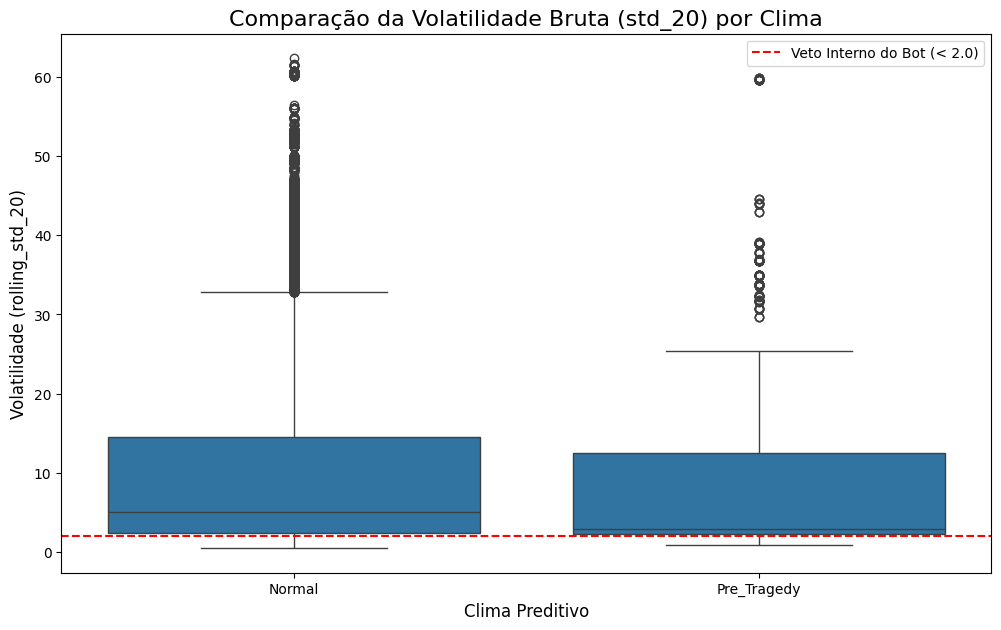

In [6]:
# --- CÉLULA 6: O RAIO-X VISUAL (Box Plot) ---
# (Pode ser necessário instalar: pip install seaborn)
import seaborn as sns
import matplotlib.pyplot as plt

# Vamos focar apenas nos climas relevantes
df_para_plot = df_final[df_final['clima_preditivo'].isin(['Normal', 'Pre_Tragedy'])]

print("Gerando gráfico de comparação...")

# Define o tamanho da figura
plt.figure(figsize=(12, 7))

# Cria um Box Plot (gráfico de caixas)
sns.boxplot(
    data=df_para_plot,
    x='clima_preditivo',
    y='rolling_std_20', # A métrica que estamos analisando
    order=['Normal', 'Pre_Tragedy'] # Define a ordem
)

# Adiciona uma linha horizontal no "Limite de Calma" do seu bot
plt.axhline(y=2.0, color='red', linestyle='--', label='Veto Interno do Bot (< 2.0)')
plt.legend()

plt.title('Comparação da Volatilidade Bruta (std_20) por Clima', fontsize=16)
plt.xlabel('Clima Preditivo', fontsize=12)
plt.ylabel('Volatilidade (rolling_std_20)', fontsize=12)

# Salva a imagem para referência
plt.savefig('analise_veto_interno_std_20.png')
print("Gráfico 'analise_veto_interno_std_20.png' salvo.")
plt.show()

Gerando gráfico de 'Concept Drift' (mudança ao longo do tempo)...
Calculando tendência macro da volatilidade...
Gráfico 'analise_concept_drift_std_20.png' salvo.


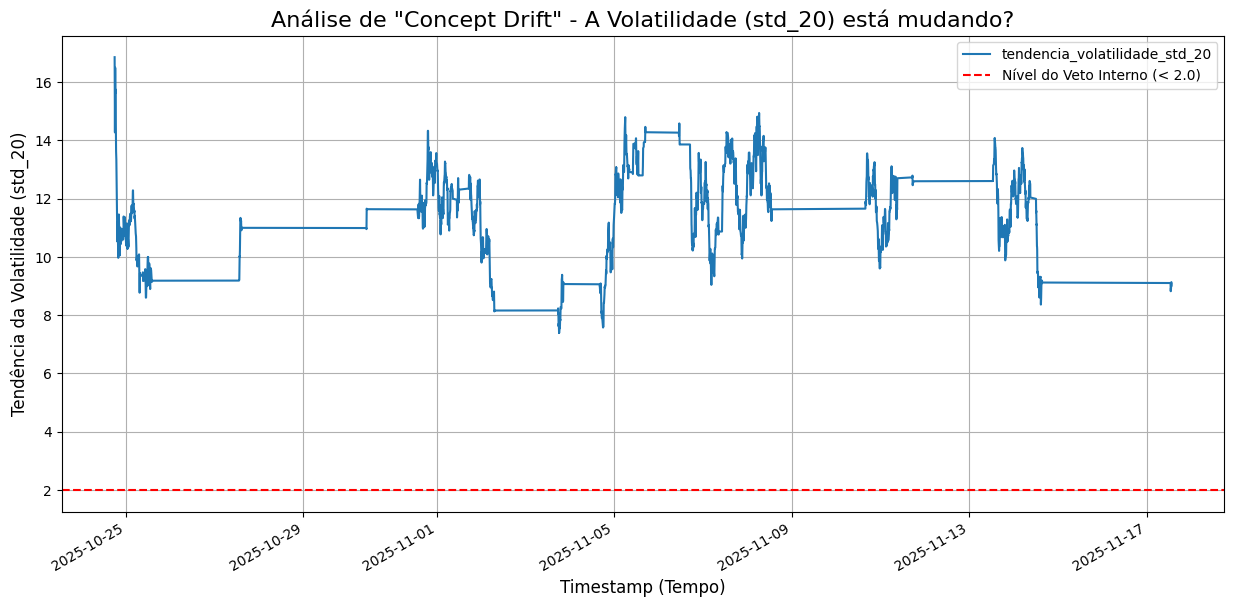

In [7]:
# --- CÉLULA 7: Análise de "Concept Drift" (Mudança de Comportamento) ---
# (Usa a variável 'df_final' das células anteriores)

import matplotlib.pyplot as plt
import seaborn as sns

print("Gerando gráfico de 'Concept Drift' (mudança ao longo do tempo)...")

# Precisamos garantir que o índice é um datetime para o plot funcionar
if not pd.api.types.is_datetime64_any_dtype(df_final.index):
    df_final.index = pd.to_datetime(df_final.index)

# Vamos plotar a "saúde" do paciente ao longo do tempo
# Usaremos a métrica do seu Veto Interno: 'rolling_std_20'
# E vamos suavizá-la (com uma média móvel de 1000) para ver a tendência macro

print("Calculando tendência macro da volatilidade...")
df_final['tendencia_volatilidade_std_20'] = df_final['rolling_std_20'].rolling(window=1000, min_periods=100).mean()

# Plotar o gráfico
plt.figure(figsize=(15, 7))
df_final['tendencia_volatilidade_std_20'].plot()

plt.title('Análise de "Concept Drift" - A Volatilidade (std_20) está mudando?', fontsize=16)
plt.xlabel('Timestamp (Tempo)', fontsize=12)
plt.ylabel('Tendência da Volatilidade (std_20)', fontsize=12)

# Adiciona a linha do Veto
plt.axhline(y=2.0, color='red', linestyle='--', label='Nível do Veto Interno (< 2.0)')
plt.legend()
plt.grid(True)
plt.savefig('analise_concept_drift_std_20.png')
print("Gráfico 'analise_concept_drift_std_20.png' salvo.")
plt.show()